In [85]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from collections import defaultdict

sys.path.append('/Users/dane/src/datatools')
from collections import Counter
from prodhist.products import Products
from dtutil.util import print_counters

In [86]:
# define some utility functions
def keep(product, year):
    """ Returns whether product fits the active seats criteria
    
        Active seat is defined as:
        - on maintenance
        - licensed
        - purchase or term (exclude loans)
        - not partner or academic
    """
    # TODO: figure out right version for every year
    if year == 2019:
        cver = 14.0
    elif year == 2018:
        cver = 13.0
    else:
        cver = 11.0
    if product.status not in ['On Maintenance'] or\
       product.type not in ['Enterprise', 'Regional Office', 'Site'] or\
       product.ptype not in ['Purchase', 'Term']:
        return False
    else:
        try:
            if float(product.version) < cver:
                return False
        except:
            return False
        return True
    
def active_seats(products, pn_list):
    """ Returns the number of active seats per pn as a dict

        :products: products object
        :param pn_list: base part numbers (7 chars) using _
        :returns: dict of pn and count of active seats
    """
    cnt = Counter()
    for p in products.get_list():
        if keep(p) and (p.partno in pn_list):
            cnt[p.partno] += int(p.qty)

    return pd.Series(cnt)

def active_sites(products, pn_list):
    """ Returns the number of active sites with one of the part numbers
    
        :products: products object
        :param pn_list: base part numbers (7 chars) using _
        :returns: list of custids representing active sites
    """
    sites = set()
    for p in products.get_list():
        if keep(p) and (p.partno in pn_list):
            sites.add(p.custid)
    return sites

In [87]:
# get products objects
p9 = Products(date='2019-01-01')
p8 = Products(date='2018-01-01')
p7 = Products(date='2017-01-01')
p6 = Products(date='2016-01-01')
p5 = Products(date='2015-01-01')

In [88]:
# since reps can change we want a map of the 2019 reps by custid
# to apply them to prior years for consistency
rep_by_custid = {}
for p in p9.get_list():
    rep_by_custid[p.custid] = p.territory

cmap = {'ANE': 'EU',
 'ATK': 'AP',
 'AWR-AP': 'AP',
 'AWR-APL': 'EU',
 'AWR-AU': 'AP',
 'AWR-BNL': 'EU',
 'AWR-CE': 'NA',
 'AWR-CN': 'AP',
 'AWR-DE': 'EU',
 'AWR-EU': 'EU',
 'AWR-FR': 'EU',
 'AWR-IL': 'EU',
 'AWR-IT': 'EU',
 'AWR-JP': 'AP',
 'AWR-KR': 'AP',
 'AWR-NE': 'NA',
 'AWR-NW': 'NA',
 'AWR-RU': 'EU',
 'AWR-SC': 'EU',
 'AWR-SE': 'NA',
 'AWR-SP': 'EU',
 'AWR-SW': 'NA',
 'AWR-TSM': 'AP',
 'AWR-UK': 'EU',
 'IDA': 'AP',
 'NI-PL': 'EU',
 'RKT': 'EU',
 'ROD': 'EU',
 'RSA': 'EU',
 'WLB': 'EU',
 'WTA': 'NA',
 'MED': 'EU',
 'RSH': 'EU',
 'RSO': 'EU',
        'ETR': 'EU',
        'DSC': 'EU',
        'AWR-TSMC': 'AP',
        'SOF': 'EU',
        'RSE': 'EU',
        'RSN': 'AP',
        'NI-BR': 'NA',
        'AWR-SA': 'NA',
        'UNI': 'AP',
        'BLC': 'AP',
       }

# Product Proliferation into Accounts

**Change Log**

* Updated on 2019-02-13: Seat counts by territory added per Andrea's request
* Published on 2019-02-11

This article explores how well VSS and our EM products have proliferated through the customer base by both continent and sales territory. To do this, I looked account by account to determine, in each group, what percentage of accounts had a specific tool.

**Note: Active Seats**

This report looks only at active seats. An active seat is defined as:

- on maintenance
- licensed
- purchase or term (exclude loans)
- not partner or academic

## How many companies have Axiem

I want to determine what percentage of companies have Axiem in each continent.  A few caveats:

* This only looks at companies that have MWO with layout.  It does not make sense to include companies without layout as it is a prerequisite for EM.

To add context, I've plotted this over time for the last few years.

In [89]:
xem_list = ['XEM_001', 'XEM_100', 'MWO_146', 'MWO_186', 'MWO_246',
            'MWO_286', 'MWO_248', 'MWO_288', 'MWO_449']

mwo_list = ['MWO_105', 'MWO_106', 'MWO_125', 'MWO_126', 'MWO_146', 'MWO_166', 'MWO_186',
            'MWO_205', 'MWO_225', 'MWO_226', 'MWO_228', 'MWO_246', 'MWO_248', 'MWO_266',
            'MWO_286', 'MWO_288', 'MWO_449']

pct_cont = pd.DataFrame(columns=['Year', 'Continent', 'MWO', 'XEM', 'PCT'])
i=0
for year, products in [(2015, p5), (2016, p6), (2017, p7), (2018, p8), (2019, p9)]:
    # print(f'{year}\n----')
    d = defaultdict(dict)
    active = [x for x in products.get_list() if keep(x, year)]
    for p in active:
        if (p.partno in xem_list) or (p.partno in mwo_list):
            rep = rep_by_custid.get(p.custid, p.territory)
            try:
                continent = cmap[rep]
            except:
                print('lookup of rep {} failed'.format(rep))
                print(p)
                break
            cdict = d[continent].get(p.custid, dict(MWO=0, XEM=0, name=p.custname))
            if p.partno in xem_list:
                cdict['XEM'] = 1
            if p.partno in mwo_list:
                cdict['MWO'] = 1
            d[continent][p.custid] = cdict
    for k, v in d.items():
        # print(k, end='')
        mcnt = 0
        xcnt = 0
        for _k, _d in v.items():
            mcnt += _d['MWO']
            xcnt += _d['XEM']
        # print('  MWO={}, XEM={}, pct={:4.1f}'.format(mcnt, xcnt, xcnt/mcnt*100))
        pct_cont.loc[i, 'Year'] = year
        pct_cont.loc[i, 'Continent'] = k
        pct_cont.loc[i, 'MWO'] = mcnt
        pct_cont.loc[i, 'XEM'] = xcnt
        pct_cont.loc[i, 'PCT'] = 100 * xcnt / mcnt
        i += 1    

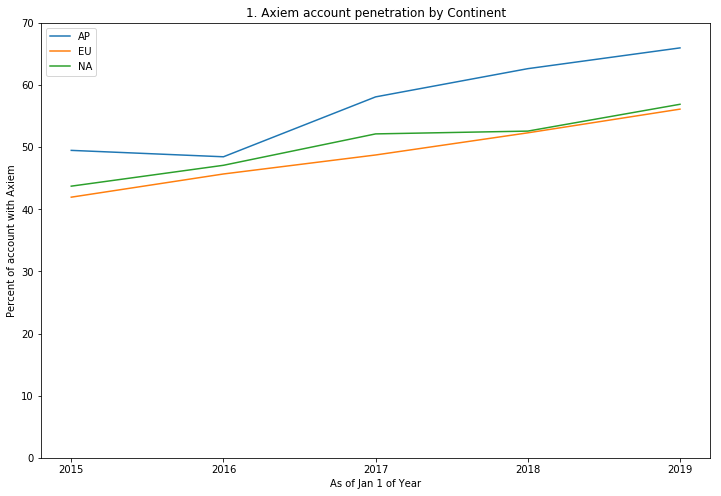

In [90]:
fig = plt.gcf()
fig.set_size_inches(12,8)
for c in ['AP', 'EU', 'NA']:
    d = pct_cont[pct_cont.Continent == c][['Year', 'PCT']]
    plt.plot(d.Year, d.PCT)
fig1_title = '1. Axiem account penetration by Continent'
fig1_data = pct_cont.copy()
plt.title(fig1_title)
plt.xlabel('As of Jan 1 of Year')
plt.ylabel('Percent of account with Axiem')
plt.xticks(d.Year.apply(int))
plt.yticks(range(0, 80, 10))
plt.legend(['AP', 'EU', 'NA'])
plt.show();

The encouraging news is that over 50% of our accounts now have Axiem and this continues to grow in all three continents.

Next, I wanted to see this broken down by sales territory for the current year.

In [91]:
d = defaultdict(dict)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'XEM', 'PCT'])
i = 0
for p in active:
    if (p.partno in xem_list) or (p.partno in mwo_list):

        cdict = d[p.territory].get(p.custid, dict(MWO=0, XEM=0, name=p.custname))
        if p.partno in xem_list:
            cdict['XEM'] = 1
        if p.partno in mwo_list:
            cdict['MWO'] = 1
        d[p.territory][p.custid] = cdict
for k, v in d.items():
    # print(k)
    mcnt = 0
    xcnt = 0
    for _k, _d in v.items():
        mcnt += _d['MWO']
        xcnt += _d['XEM']
    if mcnt >=10:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = mcnt
        df_terr.loc[i, 'XEM'] = xcnt
        df_terr.loc[i, 'PCT'] = xcnt/mcnt*100
        i += 1

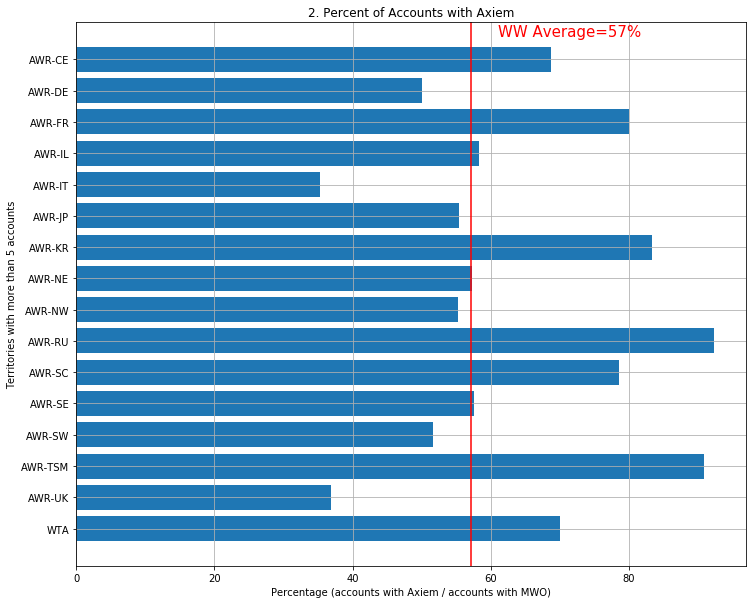

In [92]:
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (accounts with Axiem / accounts with MWO)')
plt.ylabel('Territories with more than 5 accounts')
fig2_title = '2. Percent of Accounts with Axiem'
fig2_data = df_terr.copy()
plt.title(fig2_title)
plt.axvline(x=57.1, color='red', label='average')
plt.text(61,len(data)+0.25, 'WW Average=57%', color='red', size=15)
plt.grid(True)
plt.show()

This data shows all the territories with 10 or more accounts.  In this breakdown we see that while the continent data is very similar across all 3 continents there is significantly more variation between the territories.


## How many companies have Analyst

In [93]:
ana_list = ['ANA_001', 'ANA_100', 'MWO_166', 'MWO_186',
            'MWO_266', 'MWO_286', 'MWO_288']

mwo_list = ['MWO_105', 'MWO_106', 'MWO_125', 'MWO_126', 'MWO_146', 'MWO_166', 'MWO_186',
            'MWO_205', 'MWO_225', 'MWO_226', 'MWO_228', 'MWO_246', 'MWO_248', 'MWO_266',
            'MWO_286', 'MWO_288', 'MWO_449']
pct_cont = pd.DataFrame(columns=['Year', 'Continent', 'MWO', 'ANA', 'PCT'])
i=0
for year, products in [(2015, p5), (2016, p6), (2017, p7), (2018, p8), (2019, p9)]:
    # print(f'{year}\n----')
    d = defaultdict(dict)
    active = [x for x in products.get_list() if keep(x, year)]
    for p in active:
        if (p.partno in ana_list) or (p.partno in mwo_list):
            rep = rep_by_custid.get(p.custid, p.territory)
            try:
                continent = cmap[rep]
            except:
                print(p)
                break
            cdict = d[continent].get(p.custid, dict(MWO=0, ANA=0, name=p.custname))
            if p.partno in ana_list:
                cdict['ANA'] = 1
            if p.partno in mwo_list:
                cdict['MWO'] = 1
            d[continent][p.custid] = cdict
    for k, v in d.items():
        # print(k, end='')
        mcnt = 0
        xcnt = 0
        for _k, _d in v.items():
            mcnt += _d['MWO']
            xcnt += _d['ANA']
        # print('  MWO={}, ANA={}, pct={:4.1f}'.format(mcnt, xcnt, xcnt/mcnt*100))
        pct_cont.loc[i, 'Year'] = year
        pct_cont.loc[i, 'Continent'] = k
        pct_cont.loc[i, 'MWO'] = mcnt
        pct_cont.loc[i, 'ANA'] = xcnt
        pct_cont.loc[i, 'PCT'] = 100 * xcnt / mcnt
        i += 1    

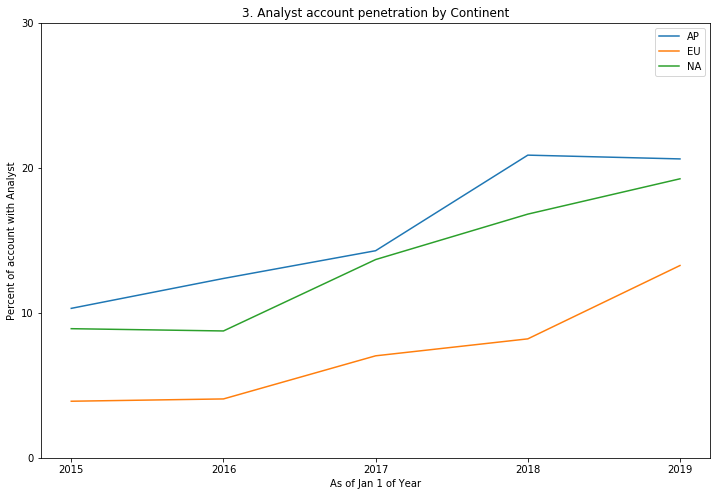

In [94]:
fig = plt.gcf()
fig.set_size_inches(12,8)
for c in ['AP', 'EU', 'NA']:
    d = pct_cont[pct_cont.Continent == c][['Year', 'PCT']]
    plt.plot(d.Year, d.PCT)
fig3_title = '3. Analyst account penetration by Continent'
fig3_data = pct_cont.copy()
plt.title(fig3_title)
plt.xlabel('As of Jan 1 of Year')
plt.ylabel('Percent of account with Analyst')
plt.xticks(d.Year.apply(int))
plt.yticks(range(0, 40, 10))
plt.legend(['AP', 'EU', 'NA'])
plt.show();

While the growth in Europe started late, it seems that it is working on making up that gap and there is solid growth in all continents at this point.

In [95]:
d = defaultdict(dict)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'ANA', 'PCT'])
i = 0
for p in [x for x in p9.get_list() if keep(x, 2019)]:
    if (p.partno in ana_list) or (p.partno in mwo_list):

        cdict = d[p.territory].get(p.custid, dict(MWO=0, ANA=0, name=p.custname))
        if p.partno in ana_list:
            cdict['ANA'] = 1
        if p.partno in mwo_list:
            cdict['MWO'] = 1
        d[p.territory][p.custid] = cdict
for k, v in d.items():
    # print(k)
    mcnt = 0
    xcnt = 0
    for _k, _d in v.items():
        mcnt += _d['MWO']
        xcnt += _d['ANA']
    if mcnt >= 10:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = mcnt
        df_terr.loc[i, 'ANA'] = xcnt
        df_terr.loc[i, 'PCT'] = xcnt/mcnt*100
        i += 1

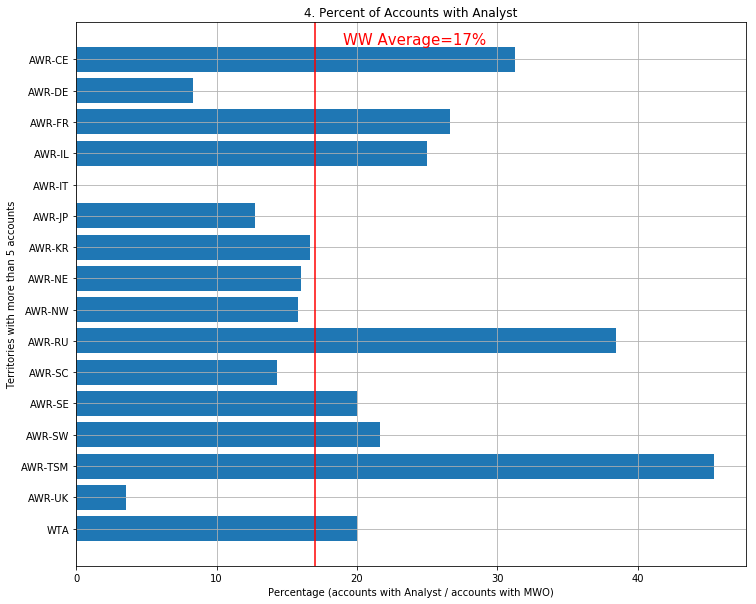

In [96]:
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (accounts with Analyst / accounts with MWO)')
fig4_title = '4. Percent of Accounts with Analyst'
fig4_data = df_terr.copy()
plt.ylabel('Territories with more than 5 accounts')
plt.title(fig4_title)
plt.axvline(x=17, color='red', label='average')
plt.text(19,len(data), 'WW Average=17%', color='red', size=15)
plt.grid(True)
plt.show()

While many territories hover around the average it is hard to miss Italy, Germany and the UK percentages.  It is less clear whether this is an issue of account type, sales/training focus or just a resource issue but these territories seem like an opportunity.

## A look at VSS

For VSS I have included MWO_100/101 and MWO_200 since there is no layout prerequisite for VSS.

In [97]:
vss_list = ['VSS_150', 'VSS_250', 'VSS_350']

mwo_list = ['MWO_105', 'MWO_106', 'MWO_125', 'MWO_126', 'MWO_146', 'MWO_166', 'MWO_186',
            'MWO_205', 'MWO_225', 'MWO_226', 'MWO_228', 'MWO_246', 'MWO_248', 'MWO_266',
            'MWO_286', 'MWO_288', 'MWO_449', 'MWO_100', 'MWO_101', 'MWO_200']
pct_cont = pd.DataFrame(columns=['Year', 'Continent', 'MWO', 'VSS', 'PCT'])
i=0
for year, products in [(2015, p5), (2016, p6), (2017, p7), (2018, p8), (2019, p9)]:
    # print(f'{year}\n----')
    d = defaultdict(dict)
    active = [x for x in products.get_list() if keep(x, year)]
    for p in active:
        if (p.partno in vss_list) or (p.partno in mwo_list):
            rep = rep_by_custid.get(p.custid, p.territory)
            try:
                continent = cmap[rep]
            except:
                print(p)
                break
            cdict = d[continent].get(p.custid, dict(MWO=0, VSS=0, name=p.custname))
            if p.partno in vss_list:
                cdict['VSS'] = 1
                cdict['MWO'] = 1  # if they have VSS could have sim only mwo
            if p.partno in mwo_list:
                cdict['MWO'] = 1
            d[continent][p.custid] = cdict

    if year == 2018:
        eud_2018 = d['EU']
    elif year == 2019:
        eud_2019 = d['EU']
    for k, v in d.items():

        mcnt = 0
        xcnt = 0
        for _k, _d in v.items():
            mcnt += _d['MWO']
            xcnt += _d['VSS']  # only count vss if there is an mwo
        # print('  MWO={}, VSS={}, pct={:4.1f}'.format(mcnt, xcnt, xcnt/mcnt*100))
        pct_cont.loc[i, 'Year'] = year
        pct_cont.loc[i, 'Continent'] = k
        pct_cont.loc[i, 'MWO'] = mcnt
        pct_cont.loc[i, 'VSS'] = xcnt
        pct_cont.loc[i, 'PCT'] = 100 * xcnt / mcnt
        i += 1

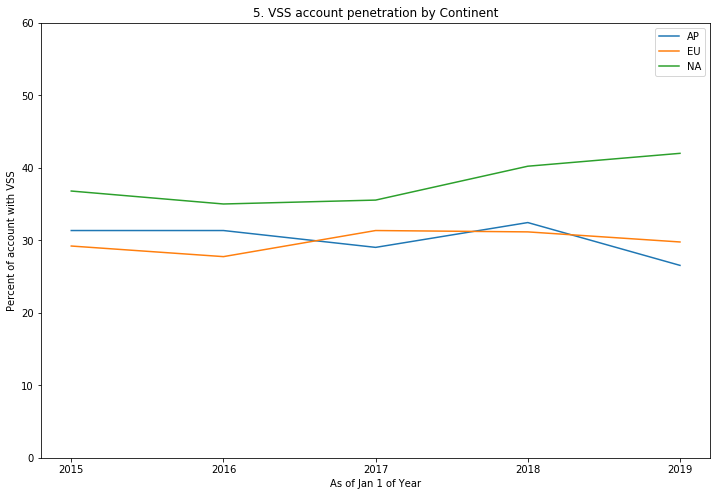

In [98]:
fig = plt.gcf()
fig.set_size_inches(12,8)
for c in ['AP', 'EU', 'NA']:
    d = pct_cont[pct_cont.Continent == c][['Year', 'PCT']]
    plt.plot(d.Year, d.PCT)
fig5_title = '5. VSS account penetration by Continent'
plt.title(fig5_title)
fig5_data = pct_cont.copy()
plt.xlabel('As of Jan 1 of Year')
plt.ylabel('Percent of account with VSS')
plt.xticks(d.Year.apply(int))
plt.yticks(range(0, 70, 10))
plt.legend(['AP', 'EU', 'NA'])
plt.show();

While we have seen gains in the bookings generated by VSS, when we look at account penetration we a somewhat different story.  We see a decrease in AP which is likely due to pirates not renewing maintenance on the VSS licenses.  The only continent where we see growth is in North America and even there the growth is small.

In [99]:
d = defaultdict(dict)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'VSS', 'PCT'])
i = 0
for p in [x for x in p9.get_list() if keep(x, 2019)]:
    if (p.partno in vss_list) or (p.partno in mwo_list):

        cdict = d[p.territory].get(p.custid, dict(MWO=0, VSS=0, name=p.custname))
        if p.partno in vss_list:
            cdict['VSS'] = 1
        if p.partno in mwo_list:
            cdict['MWO'] = 1
        d[p.territory][p.custid] = cdict
#         if p.territory == 'AWR-TSM':
#             print(p.custname)
for k, v in d.items():
    # print(k)
    mcnt = 0
    xcnt = 0
    for _k, _d in v.items():
        mcnt += _d['MWO']
        xcnt += _d['VSS']
    if mcnt >=10:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = mcnt
        df_terr.loc[i, 'VSS'] = xcnt
        df_terr.loc[i, 'PCT'] = xcnt/mcnt*100
        i += 1

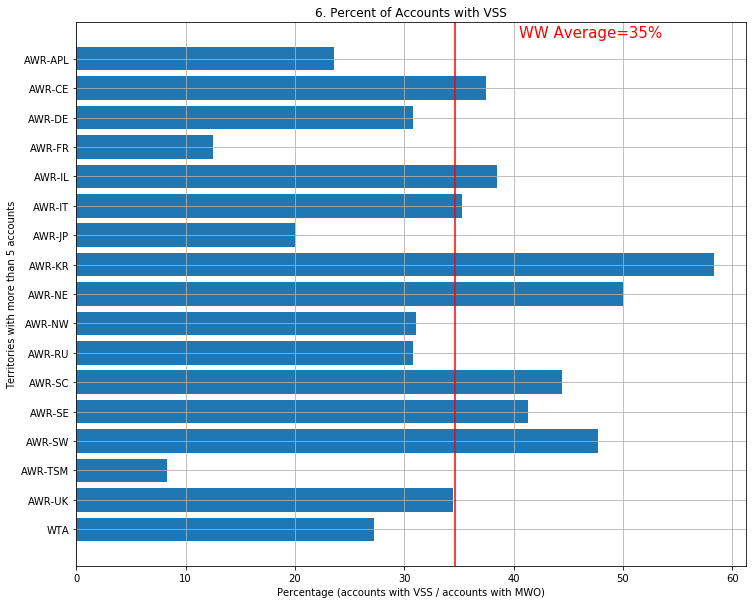

In [100]:
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (accounts with VSS / accounts with MWO)')
plt.ylabel('Territories with more than 5 accounts')
fig6_title = '6. Percent of Accounts with VSS'
plt.title(fig6_title)
fig6_data = df_terr.copy()
plt.axvline(x=34.6, color='red', label='average')
plt.text(40.5,len(data)+0.25, 'WW Average=35%', color='red', size=15)
plt.grid(True)
plt.show()

As in the Analyst case there are some territories here that stand out as opportunities starting with Japan, Taiwan, Singapore as well as France.  My understanding is these are all resource issues (given our failed attempt to hire a VSS person in Taiwan last year) and the lack of resource in France.

## A look from the seat count perspective

My first instinct was to look at seat counts rather than by accounts. In thinking about it, I felt that looking at seat counts had the following issues:

* the number of seats varies widely between territories.
* large accounts (especially AYCE ones) can skew the seat count numbers significantly
* it's hard to know what we're shooting for, is a territory that sells 5 XEM and 5 MWO better or worse than a territory that sells 50 XEM and 100 MWO from a proliferation perspective?

Because of these reasons I decided to look at this from the account perspective.  After releasing the report, Andrea asked for the data from the seat perspective.  In discussing it, I agreed that it provides a different perspective and is does augment the understanding of our accounts so I have added it below.

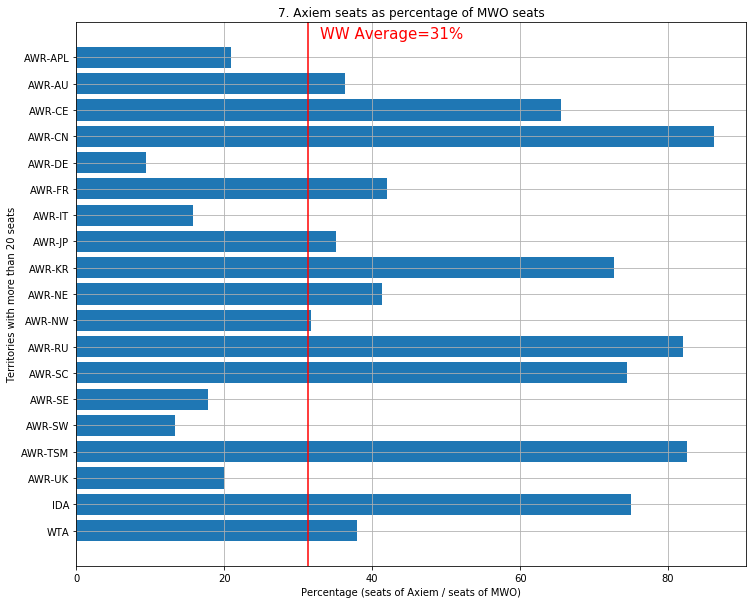

In [113]:
active = [x for x in p9.get_list() if keep(x, 2019)]
d = defaultdict(Counter)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'XEM', 'PCT'])
i = 0
for p in active:
    if (p.partno in xem_list) or (p.partno in mwo_list):
        cdict = d[p.territory]
        if p.partno in xem_list:
            cdict['XEM'] += int(p.qty)
        if p.partno in mwo_list:
            cdict['MWO'] += int(p.qty)

for k, v in d.items():
    if v['MWO'] >=20:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = v['MWO']
        df_terr.loc[i, 'XEM'] = v['XEM']
        df_terr.loc[i, 'PCT'] = v['XEM'] / v['MWO'] * 100
        i += 1
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (seats of Axiem / seats of MWO)')
plt.ylabel('Territories with more than 20 seats')
fig7_title = '7. Axiem seats as percentage of MWO seats'
plt.title(fig7_title)
fig7_data = df_terr.copy()
plt.axvline(x=31.3, color='red', label='average')
plt.text(33,len(data)+0.25, 'WW Average=31%', color='red', size=15)
plt.grid(True)
plt.show()

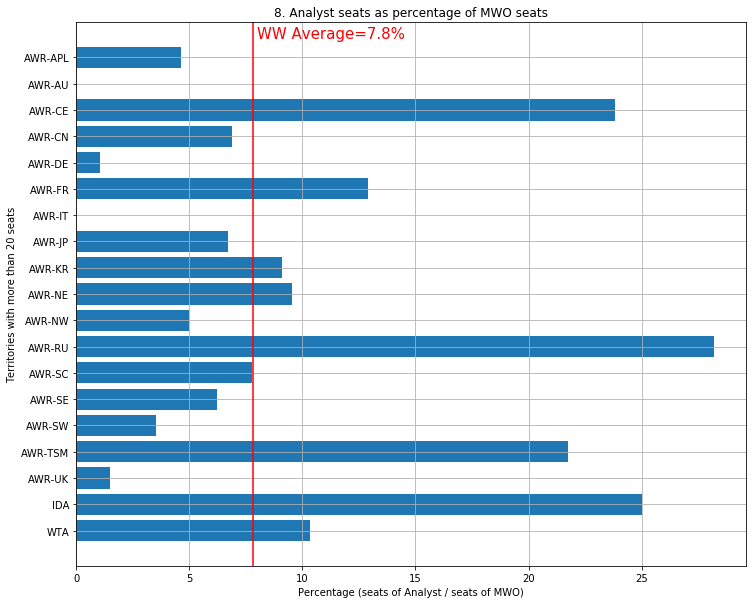

In [114]:
d = defaultdict(Counter)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'ANA', 'PCT'])
i = 0
for p in active:
    if (p.partno in ana_list) or (p.partno in mwo_list):
        cdict = d[p.territory]
        if p.partno in ana_list:
            cdict['ANA'] += int(p.qty)
        if p.partno in mwo_list:
            cdict['MWO'] += int(p.qty)

for k, v in d.items():
    if v['MWO'] >=20:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = v['MWO']
        df_terr.loc[i, 'ANA'] = v['ANA']
        df_terr.loc[i, 'PCT'] = v['ANA'] / v['MWO'] * 100
        i += 1
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (seats of Analyst / seats of MWO)')
plt.ylabel('Territories with more than 20 seats')
fig8_title = '8. Analyst seats as percentage of MWO seats'
plt.title(fig8_title)
fig8_data = df_terr.copy()
plt.axvline(x=7.8, color='red', label='average')
plt.text(8,len(data)+0.25, 'WW Average=7.8%', color='red', size=15)
plt.grid(True)
plt.show()

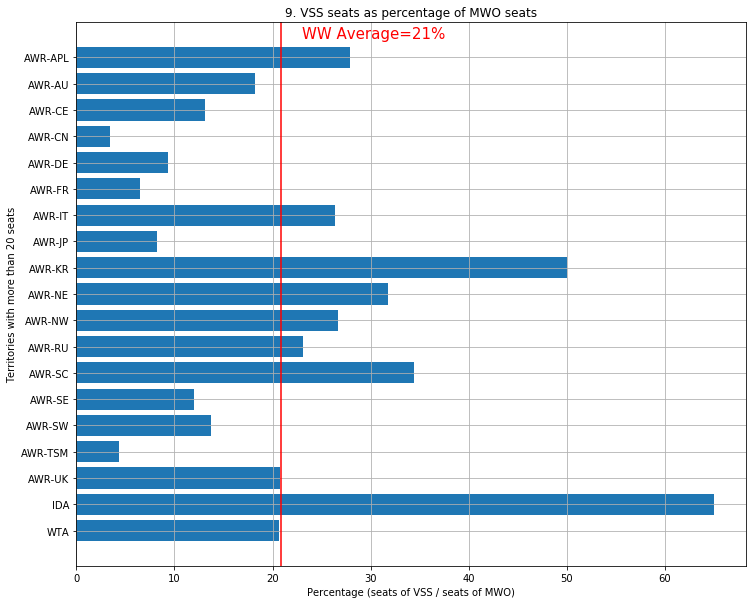

In [115]:
d = defaultdict(Counter)
df_terr = pd.DataFrame(columns=['Territory', 'MWO', 'VSS', 'PCT'])
i = 0
for p in active:
    if (p.partno in vss_list) or (p.partno in mwo_list):
        cdict = d[p.territory]
        if p.partno in vss_list:
            cdict['VSS'] += int(p.qty)
        if p.partno in mwo_list:
            cdict['MWO'] += int(p.qty)

for k, v in d.items():
    if v['MWO'] >=20:
        df_terr.loc[i, 'Territory'] = k
        df_terr.loc[i, 'MWO'] = v['MWO']
        df_terr.loc[i, 'VSS'] = v['VSS']
        df_terr.loc[i, 'PCT'] = v['VSS'] / v['MWO'] * 100
        i += 1
data = df_terr[['Territory', 'PCT']]
data = pd.Series(data.set_index('Territory').PCT).sort_index(ascending=False)
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(12,10) 

ax = plt.barh(pos,data, align='center')
plt.yticks(pos, data.index)
plt.xlabel('Percentage (seats of VSS / seats of MWO)')
plt.ylabel('Territories with more than 20 seats')
fig9_title = '9. VSS seats as percentage of MWO seats'
plt.title(fig9_title)
fig9_data = df_terr.copy()
plt.axvline(x=20.9, color='red', label='average')
plt.text(23,len(data)+0.25, 'WW Average=21%', color='red', size=15)
plt.grid(True)
plt.show()

## Data Tables for Graphs Above

In [116]:
print(fig1_title)
fig1_data

1. Axiem account penetration by Continent


,Year,Continent,MWO,XEM,PCT
0,2015,NA,247,108,43.7247
1,2015,EU,205,86,41.9512
2,2015,AP,97,48,49.4845
3,2016,NA,240,113,47.0833
4,2016,EU,197,90,45.6853
5,2016,AP,97,47,48.4536
6,2017,NA,234,122,52.1368
7,2017,EU,199,97,48.7437
8,2017,AP,105,61,58.0952
9,2018,NA,232,122,52.5862


In [117]:
print(fig2_title)
fig2_data.sort_values(by='Territory')

2. Percent of Accounts with Axiem


,Territory,MWO,XEM,PCT
10,AWR-CE,16,11,68.75
8,AWR-DE,12,6,50
9,AWR-FR,15,12,80
13,AWR-IL,12,7,58.3333
11,AWR-IT,17,6,35.2941
7,AWR-JP,47,26,55.3191
15,AWR-KR,12,10,83.3333
1,AWR-NE,75,43,57.3333
2,AWR-NW,38,21,55.2632
14,AWR-RU,26,24,92.3077


In [118]:
print(fig3_title)
fig3_data

3. Analyst account penetration by Continent


,Year,Continent,MWO,ANA,PCT
0,2015,NA,247,22,8.90688
1,2015,EU,205,8,3.90244
2,2015,AP,97,10,10.3093
3,2016,NA,240,21,8.75
4,2016,EU,197,8,4.06091
5,2016,AP,97,12,12.3711
6,2017,NA,234,32,13.6752
7,2017,EU,199,14,7.03518
8,2017,AP,105,15,14.2857
9,2018,NA,232,39,16.8103


In [119]:
print(fig4_title)
fig4_data.sort_values(by='Territory')

4. Percent of Accounts with Analyst


,Territory,MWO,ANA,PCT
10,AWR-CE,16,5,31.25
8,AWR-DE,12,1,8.33333
9,AWR-FR,15,4,26.6667
13,AWR-IL,12,3,25
11,AWR-IT,17,0,0
7,AWR-JP,47,6,12.766
15,AWR-KR,12,2,16.6667
1,AWR-NE,75,12,16
2,AWR-NW,38,6,15.7895
14,AWR-RU,26,10,38.4615


In [120]:
print(fig5_title)
fig5_data

5. VSS account penetration by Continent


,Year,Continent,MWO,VSS,PCT
0,2015,AP,118,37,31.3559
1,2015,NA,288,106,36.8056
2,2015,EU,243,71,29.2181
3,2016,NA,277,97,35.0181
4,2016,EU,245,68,27.7551
5,2016,AP,118,37,31.3559
6,2017,NA,270,96,35.5556
7,2017,EU,236,74,31.3559
8,2017,AP,124,36,29.0323
9,2018,NA,261,105,40.2299


In [121]:
print(fig6_title)
fig6_data.sort_values(by='Territory')

6. Percent of Accounts with VSS


,Territory,MWO,VSS,PCT
14,AWR-APL,17,4,23.5294
10,AWR-CE,16,6,37.5
8,AWR-DE,13,4,30.7692
9,AWR-FR,16,2,12.5
13,AWR-IL,13,5,38.4615
11,AWR-IT,17,6,35.2941
7,AWR-JP,55,11,20
16,AWR-KR,12,7,58.3333
1,AWR-NE,78,39,50
2,AWR-NW,45,14,31.1111


In [122]:
print(fig7_title)
fig7_data.sort_values(by='Territory')

7. Axiem seats as percentage of MWO seats


,Territory,MWO,XEM,PCT
15,AWR-APL,43,9,20.9302
12,AWR-AU,22,8,36.3636
10,AWR-CE,84,55,65.4762
18,AWR-CN,29,25,86.2069
8,AWR-DE,96,9,9.375
9,AWR-FR,31,13,41.9355
11,AWR-IT,38,6,15.7895
7,AWR-JP,134,47,35.0746
17,AWR-KR,22,16,72.7273
1,AWR-NE,220,91,41.3636


In [123]:
print(fig8_title)
fig8_data.sort_values(by='Territory')

8. Analyst seats as percentage of MWO seats


,Territory,MWO,ANA,PCT
15,AWR-APL,43,2,4.65116
12,AWR-AU,22,0,0
10,AWR-CE,84,20,23.8095
18,AWR-CN,29,2,6.89655
8,AWR-DE,96,1,1.04167
9,AWR-FR,31,4,12.9032
11,AWR-IT,38,0,0
7,AWR-JP,134,9,6.71642
17,AWR-KR,22,2,9.09091
1,AWR-NE,220,21,9.54545


In [124]:
print(fig9_title)
fig9_data.sort_values(by='Territory')

9. VSS seats as percentage of MWO seats


,Territory,MWO,VSS,PCT
15,AWR-APL,43,12,27.907
12,AWR-AU,22,4,18.1818
10,AWR-CE,84,11,13.0952
18,AWR-CN,29,1,3.44828
8,AWR-DE,96,9,9.375
9,AWR-FR,31,2,6.45161
11,AWR-IT,38,10,26.3158
7,AWR-JP,134,11,8.20896
17,AWR-KR,22,11,50
1,AWR-NE,220,70,31.8182
